Epoch 1/50, Train Accuracy: 96.4124, Test Accuracy: 94.0439
Epoch 2/50, Train Accuracy: 97.4922, Test Accuracy: 95.9248
Epoch 3/50, Train Accuracy: 97.6315, Test Accuracy: 93.7304
Epoch 4/50, Train Accuracy: 98.9202, Test Accuracy: 95.2978
Epoch 5/50, Train Accuracy: 98.2933, Test Accuracy: 95.2978
Epoch 6/50, Train Accuracy: 99.0944, Test Accuracy: 94.6708
Epoch 7/50, Train Accuracy: 99.2337, Test Accuracy: 94.9843
Epoch 8/50, Train Accuracy: 99.5820, Test Accuracy: 94.0439
Epoch 9/50, Train Accuracy: 99.4427, Test Accuracy: 94.6708
Epoch 10/50, Train Accuracy: 99.6517, Test Accuracy: 94.0439
Epoch 11/50, Train Accuracy: 99.8607, Test Accuracy: 94.3574
Epoch 12/50, Train Accuracy: 99.5472, Test Accuracy: 95.6113
Epoch 13/50, Train Accuracy: 99.8955, Test Accuracy: 94.9843
Epoch 14/50, Train Accuracy: 99.8607, Test Accuracy: 94.3574
Epoch 15/50, Train Accuracy: 99.7562, Test Accuracy: 93.7304
Epoch 16/50, Train Accuracy: 99.8258, Test Accuracy: 94.9843
Epoch 17/50, Train Accuracy: 99.8

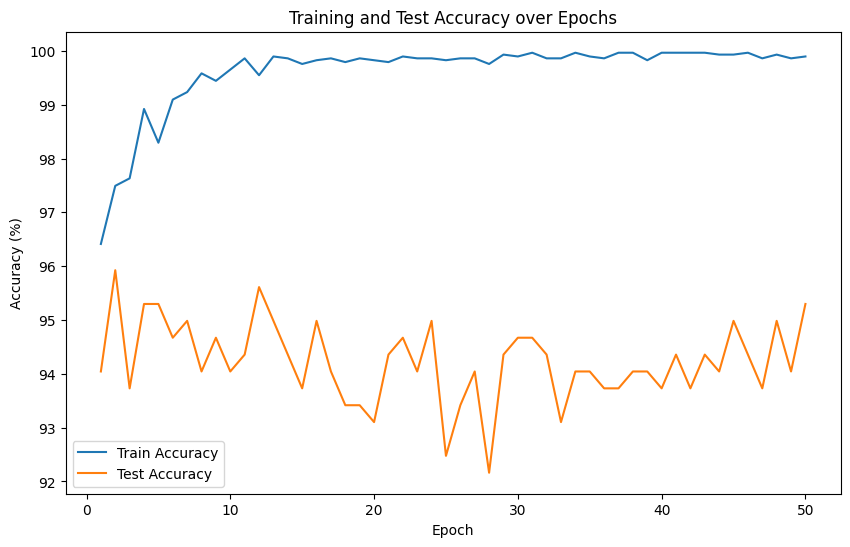

Visualizing explanation for test sequence 1


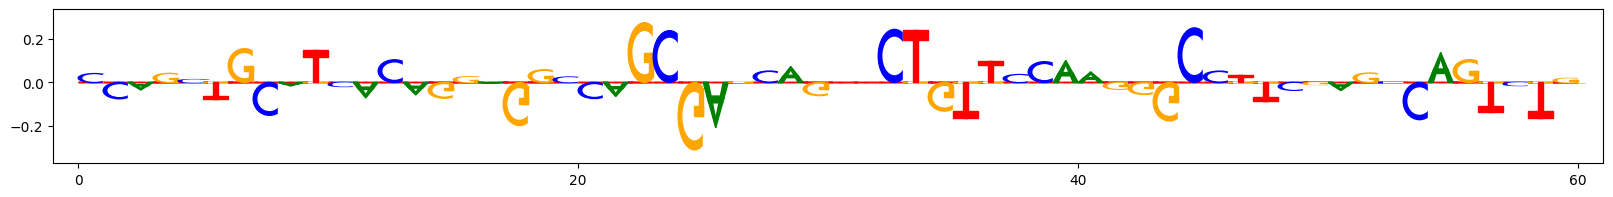

Visualizing explanation for test sequence 2


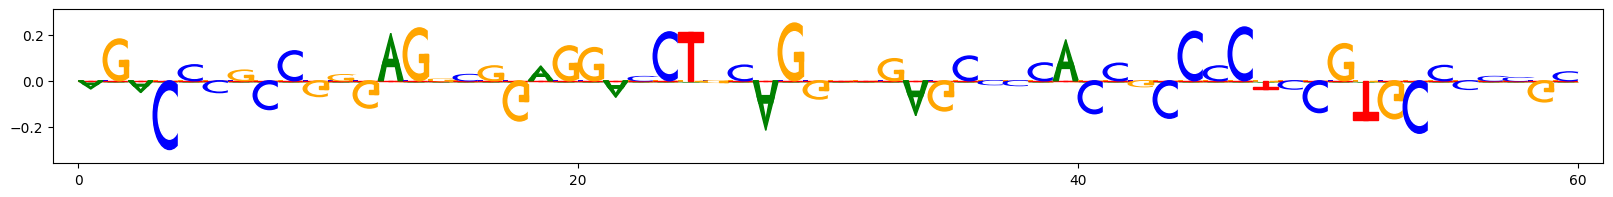

Visualizing explanation for test sequence 3


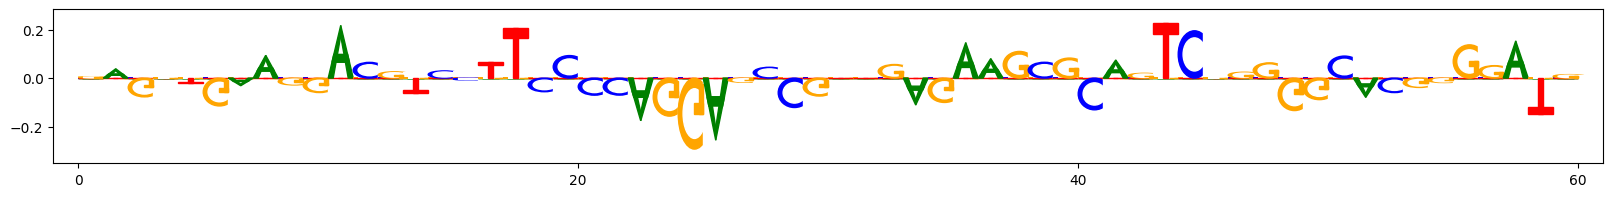

Visualizing explanation for test sequence 4


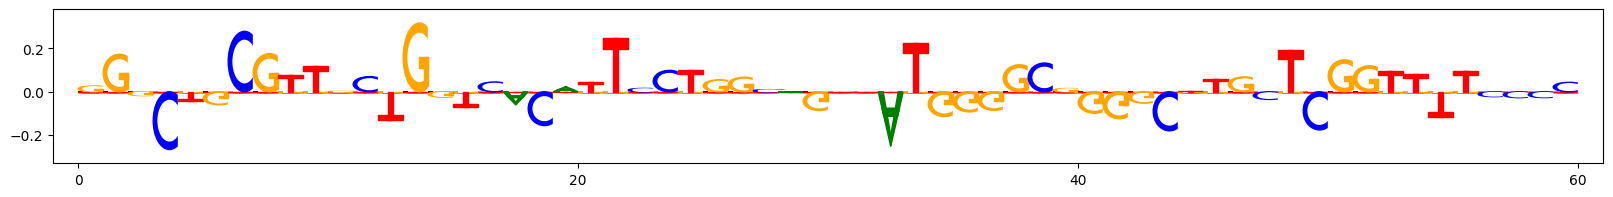

Visualizing explanation for test sequence 5


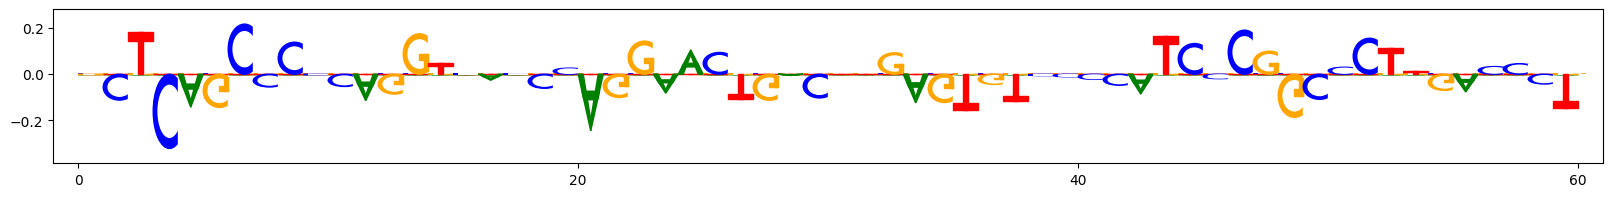

Visualizing explanation for test sequence 6


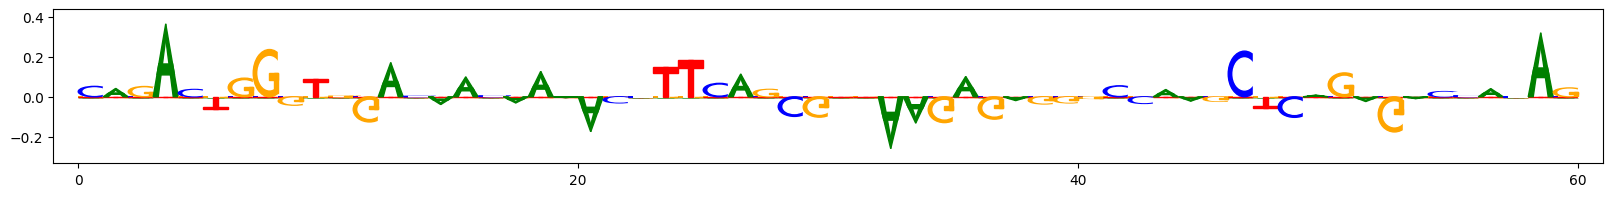

Visualizing explanation for test sequence 7


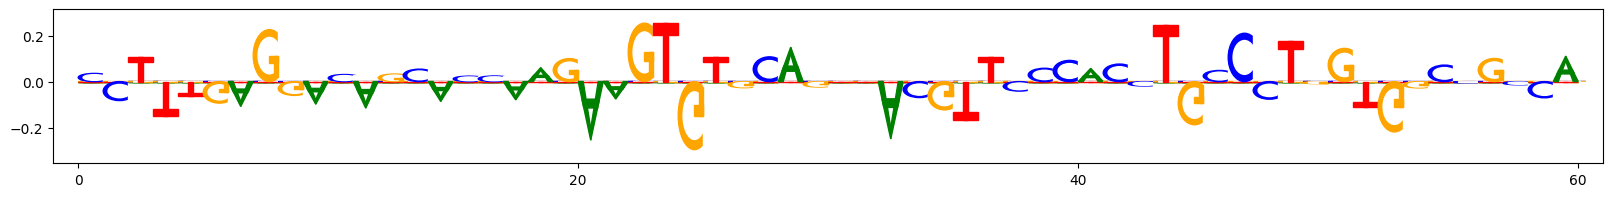

Visualizing explanation for test sequence 8


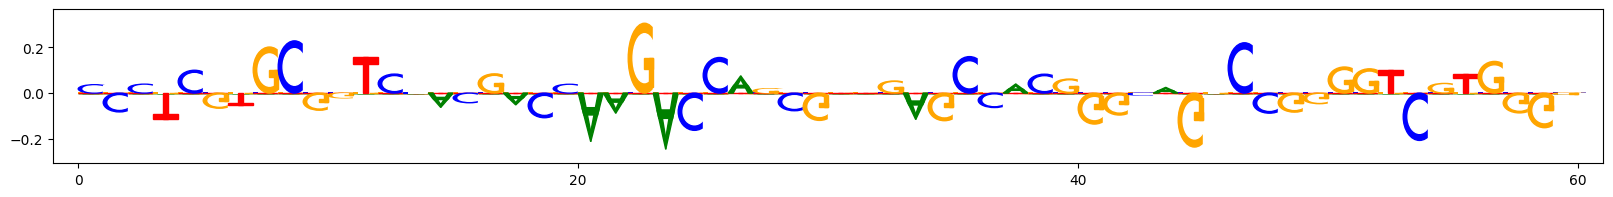

Visualizing explanation for test sequence 9


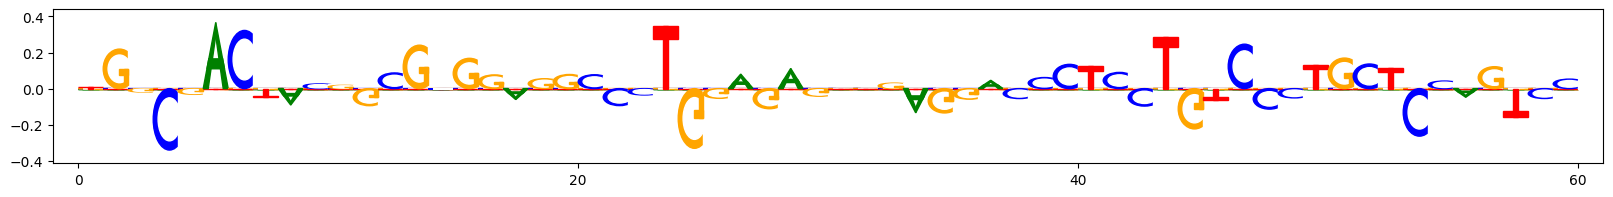

Visualizing explanation for test sequence 10


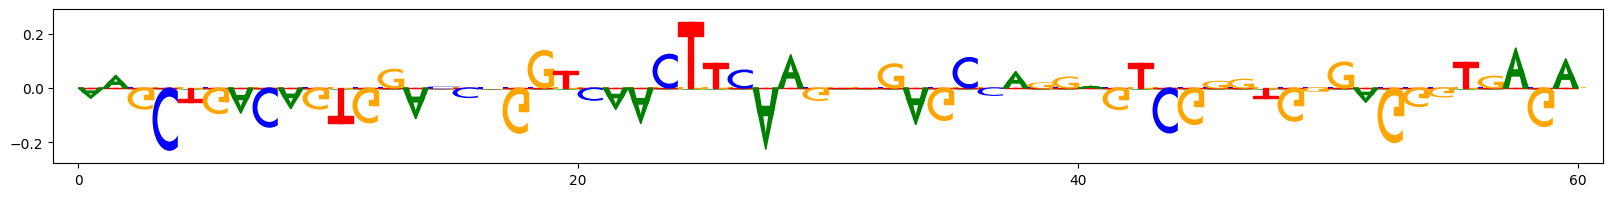

DeepLIFT analysis and visualizations complete.


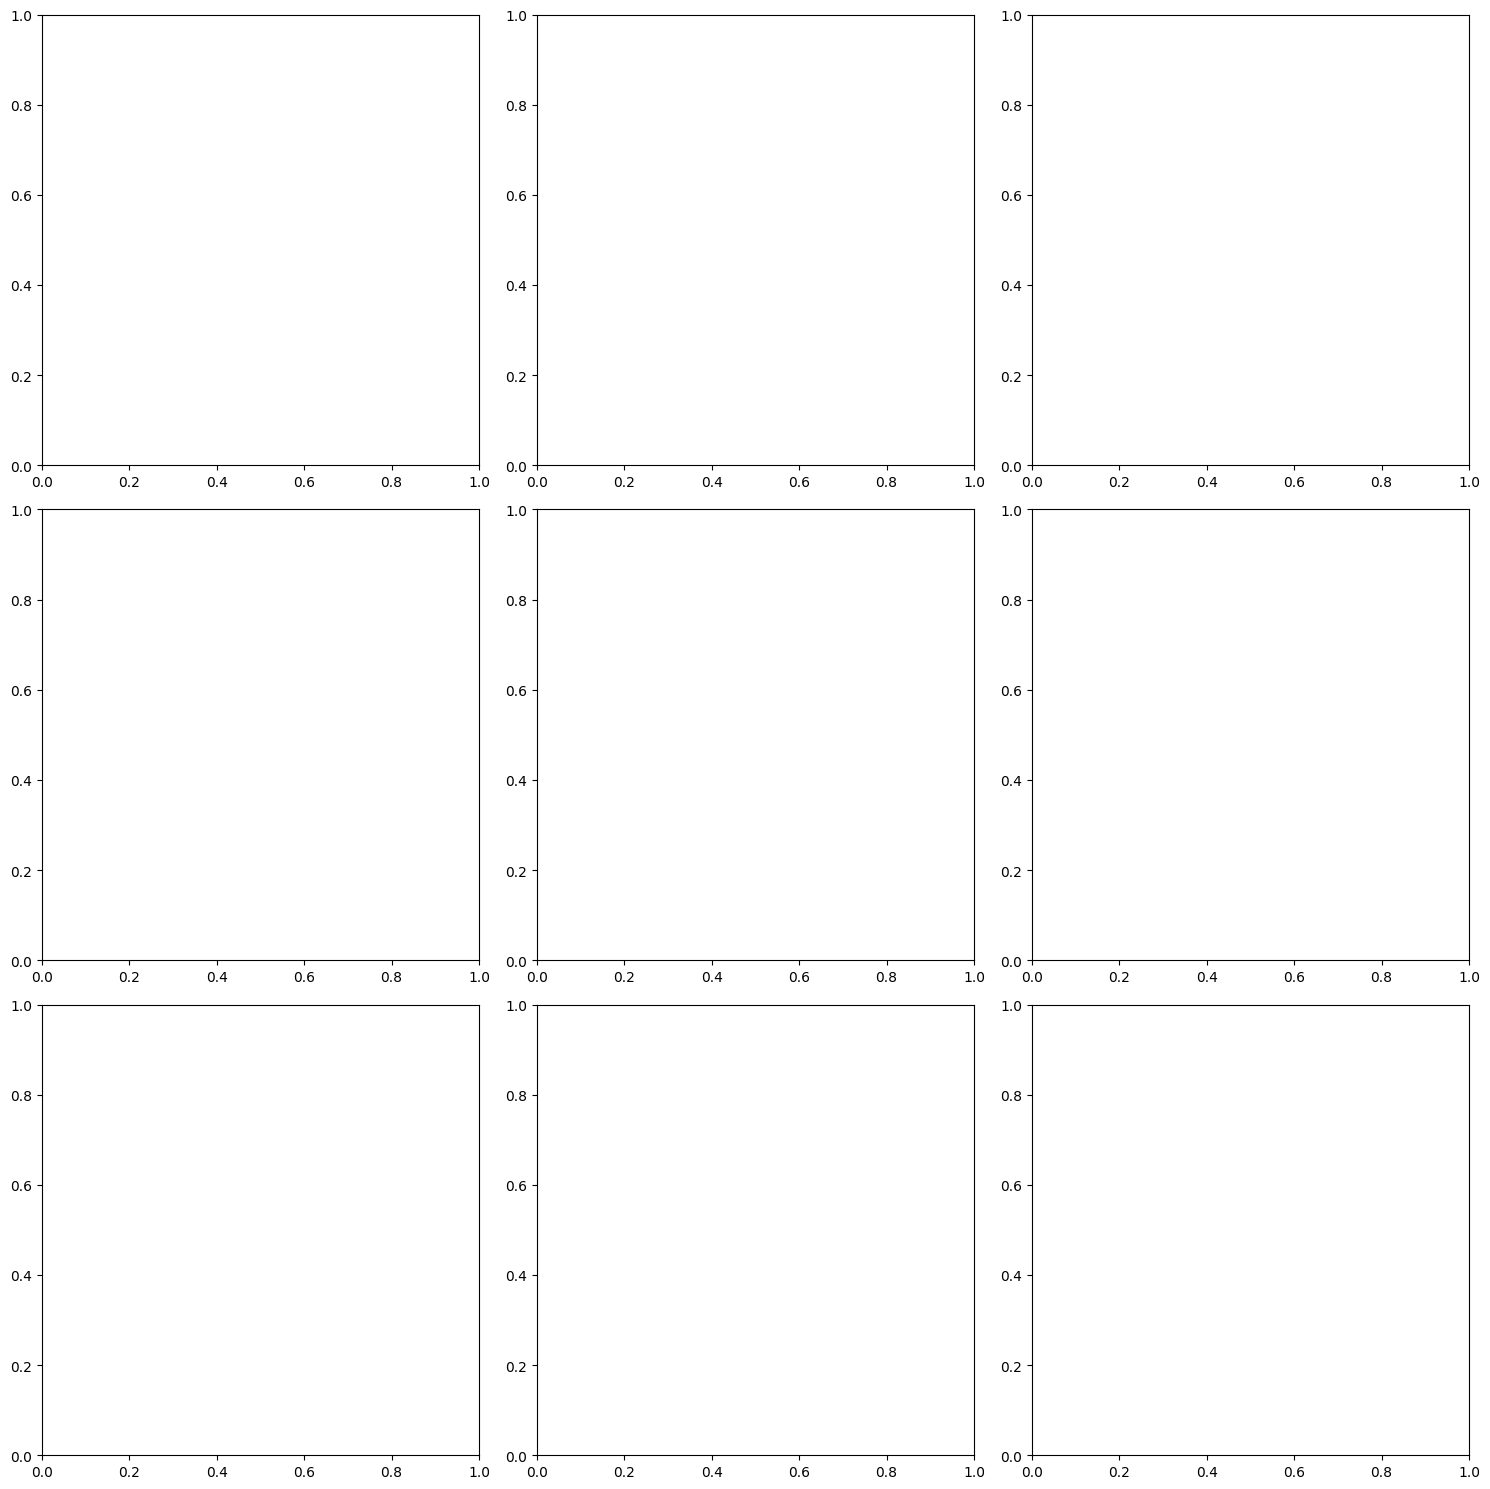

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from ucimlrepo import fetch_ucirepo
import shap
from deeplift.visualization import viz_sequence
import matplotlib.pyplot as plt
from deeplift.dinuc_shuffle import dinuc_shuffle

# CNN model
class SpliceCNN(nn.Module):
    def __init__(self, input_size, num_classes, kernel_size=5):
        super(SpliceCNN, self).__init__()
        self.conv1 = nn.Conv1d(4, 8, kernel_size=kernel_size, padding=0)
        self.fc1 = nn.Linear(8 * (input_size - kernel_size + 1), 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.fc2(x)
        return x


# nucleotide dataset class
class SpliceDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        label = self.labels[idx]
        return seq, label


# one-hot DNA encoder
def encode_dna(seq):
    encoding = {'A': [1,0,0,0], 
                'C': [0,1,0,0], 
                'G': [0,0,1,0], 
                'T': [0,0,0,1],
                'D': [1/3,0,1/3,1/3],
                'N': [1/4,1/4,1/4,1/4],
                'S': [0,1/2,1/2,0],
                'R': [1/2,0,1/2,0]}
    
    return np.array([encoding.get(base, [0,0,0,0]) for base in seq])


# load and encode sequence data
def load_data():
    # fetch dataset
    raw_sequences = fetch_ucirepo(id=69)

    # extract DNA sequences and labels
    sequences = raw_sequences.data.features.values
    labels = raw_sequences.data.targets.values.reshape(-1,)

    le = LabelEncoder()
    y = le.fit_transform(labels)

    # to torch tensor
    encoded_sequences = np.array([encode_dna(seq) for seq in sequences])
    encoded_sequences = torch.FloatTensor(encoded_sequences).permute(0, 2, 1)
    labels = torch.LongTensor(y)

    return encoded_sequences, labels


def train_model(model, train_loader, criterion, optimizer, device):
    model.train()

    for sequences, labels in train_loader:
        optimizer.zero_grad()

        # forward pass
        sequences, labels = sequences.to(device), labels.to(device)
        outputs = model(sequences)

        loss = criterion(outputs, labels)

        # backward pass
        loss.backward()
        optimizer.step()


def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for sequences, labels in test_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            
            # Get predicted class from outputs
            _, predicted = torch.max(outputs.data, 1)
            
            # Update total and correct counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Calculate accuracy
    classification_accuracy = 100 * correct / total
    return classification_accuracy


def plot_accuracies(train_accuracies, test_accuracies):
    epochs = range(1, len(train_accuracies) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Test Accuracy over Epochs')
    plt.legend()
    plt.show()


def shuffle_several_times(s):
    s = np.squeeze(s)
    return dinuc_shuffle(s, num_shufs=100)


def deeplift_analysis(model, encoded_sequences, device):
    # Set model to evaluation mode
    model.eval()
    
    # Move model to CPU for SHAP compatibility (SHAP may not work properly with CUDA)
    model = model.to('cpu')
    
    # Use DeepExplainer to compute SHAP values
    explainer = shap.DeepExplainer(model, encoded_sequences[:100])  # Use a subset of sequences as background
    shap_values = explainer.shap_values(encoded_sequences[:10])  # Explaining the first 10 test sequences

    # Visualize the explanations for some test sequences
    for i in range(len(shap_values)):
        print(f"Visualizing explanation for test sequence {i+1}")
        
        # Project the SHAP values onto the base that is actually present in each position
        shap_seq = shap_values[i].sum(axis=-1) * encoded_sequences[i].detach().numpy()
        
        # Convert the explanation to a form that viz_sequence can use
        viz_sequence.plot_weights(shap_seq.squeeze(), subticks_frequency=20)
        plt.show()

    print("DeepLIFT analysis and visualizations complete.")


def find_confident_predictions(model, test_loader, device):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []
    all_sequences = []

    with torch.no_grad():
        for sequences, labels in test_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.append(preds.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            all_sequences.append(sequences.cpu().numpy())

    # Convert lists to numpy arrays
    all_preds = np.concatenate(all_preds)
    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)
    all_sequences = np.concatenate(all_sequences)

    # Find the most confident correct and incorrect predictions for each class
    confident_correct = {}
    confident_incorrect = {}

    for cls in range(3):  # 3 classes: Donor, Acceptor, Negative
        # Find correct predictions
        correct_mask = (all_preds == cls) & (all_labels == cls)
        incorrect_mask = (all_preds == cls) & (all_labels != cls)

        if correct_mask.sum() > 0:
            # Most confident correct prediction
            correct_probs = all_probs[correct_mask, cls]
            confident_correct[cls] = np.argmax(correct_probs)

        if incorrect_mask.sum() > 0:
            # Most confident incorrect prediction
            incorrect_probs = all_probs[incorrect_mask, cls]
            confident_incorrect[cls] = np.argmax(incorrect_probs)

    return confident_correct, confident_incorrect, all_sequences


def visualize_confident_predictions(confident_correct, confident_incorrect, all_sequences, shap_values, encoded_sequences):
    fig, axs = plt.subplots(3, 3, figsize=(15, 15))
    
    classes = ['Donor', 'Acceptor', 'Negative']
    
    for i, cls in enumerate(classes):
        # Confident correct prediction
        if cls in confident_correct:
            correct_idx = confident_correct[cls]
            shap_seq = shap_values[correct_idx].sum(axis=-1) * encoded_sequences[correct_idx].detach().numpy()
            viz_sequence.plot_weights(shap_seq.squeeze(), subticks_frequency=20, ax=axs[i, 0])
            axs[i, 0].set_title(f'{cls}: Correct Confident Prediction')
        
        # Confident incorrect prediction
        if cls in confident_incorrect:
            incorrect_idx = confident_incorrect[cls]
            shap_seq = shap_values[incorrect_idx].sum(axis=-1) * encoded_sequences[incorrect_idx].detach().numpy()
            viz_sequence.plot_weights(shap_seq.squeeze(), subticks_frequency=20, ax=axs[i, 1])
            axs[i, 1].set_title(f'{cls}: Incorrect Confident Prediction')

    plt.tight_layout()
    plt.show()


def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # load and preprocess data
    encoded_sequences, labels = load_data()

    # split data
    X_train, X_test, y_train, y_test = train_test_split(encoded_sequences, labels, 
                                                        test_size=0.1, random_state=11)

    # dataloaders
    train_dataset = SpliceDataset(X_train, y_train)
    test_dataset = SpliceDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # init model
    model = SpliceCNN(input_size=60, num_classes=3, kernel_size=4).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # train model
    num_epochs = 50
    train_accuracies = []
    test_accuracies = []
    for epoch in range(num_epochs):
        train_model(model, train_loader, criterion, optimizer, device)
        # Calculate train and test accuracy
        train_accuracy = evaluate_model(model, train_loader, device)
        test_accuracy = evaluate_model(model, test_loader, device)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # plot accuracy over epochs
    plot_accuracies(train_accuracies, test_accuracies)

    # perform DeepLIFT analysis
    deeplift_analysis(model, encoded_sequences, device)

    # Find confident predictions and visualize them
    confident_correct, confident_incorrect, all_sequences = find_confident_predictions(model, test_loader, device)
    visualize_confident_predictions(confident_correct, confident_incorrect, all_sequences, encoded_sequences, encoded_sequences)


if __name__ == "__main__":
    main()
